# CS523 - Applied AI Project
- URL: http://web.eecs.utk.edu/~acw/teaching/f21/cosc423/project.html

## Pathway #2: AI as an Application:
Building machine learning models for a particular domain setting and evaluating them appropriately, e.g. predicting /r/AITA votes with data from Reddit. Projects in this pathway should:
1. Find or collect a dataset for machine learning use.
2. Implement and train models with the dataset, i.e. with scikit-learn or Keras.
3. Design an evaluation that compares the performance of multiple models.

In [51]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 1. Introduction:
- Describe why your project matters.

# 2. Approach:
- Describe your approach.

# 3. Implementation:
- Describe your approach.


In [21]:
import sys
import tensorflow as tf


def print_info():
    print('=' * 80)
    print('Python: ' + sys.version)
    print()

    print("# Tensorflow:")
    print('\t* TensorFlow version: {version}'.format(version=tf.__version__))
    print('\t* Eager mode enabled: {mode}'.format(mode=tf.executing_eagerly()))
    print()

    cpus = tf.config.list_physical_devices('GPU')
    gpus = tf.config.list_physical_devices('GPU')

    print("# Devices:")
    print(f"\t* {len(cpus)} CPU(s):")
    print(f"\t* {len(gpus)} GPU(s):")
    for i, gpu in enumerate(gpus):
        print(f'\t\t{i + 1}. {gpu}')
    print('=' * 80)


print_info()

Python: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) 
[Clang 11.1.0 ]

# Tensorflow:
	* TensorFlow version: 2.6.0
	* Eager mode enabled: True

# Devices:
	* 1 CPU(s):
	* 1 GPU(s):
		1. PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 3.1. Read Dataset

In [62]:
from math import ceil
from art import *
from matplotlib import pyplot as plt
from IPython.core.display import display
from os import listdir
from os.path import isfile, join, basename
import numpy as np
import pandas as pd


def get_csvs_in_dir(dir_path):
    return [join(dir_path, f) for f in listdir(dir_path) if isfile(join(dir_path, f)) and f.endswith('.csv')]


def plot_data(df, title='Dataset', n_cols=2, n_fullsize=1, fixed_bins=None, figsize=(12, 14)):
    cm = plt.cm.get_cmap('RdYlBu_r')

    plt.figure(figsize=figsize)
    plt.suptitle(f'{title} Dataset')

    nrows = ceil((len(df.columns) + 1) / 2)

    for ax_i, df_i in enumerate(df.columns):
        if ax_i < n_fullsize:
            plt.subplot(nrows, 1, ax_i + 1)
        else:
            plt.subplot(nrows, n_cols, ax_i + n_fullsize + 1)

        is_cat = df[df_i].apply(type).eq(str).all()
        n_unique = df[df_i].nunique()

        if fixed_bins is None:
            num_bins = n_unique if is_cat else int(n_unique / 2) if np.sqrt(n_unique) < 20 else int(np.sqrt(n_unique))
        else:
            num_bins = fixed_bins
        # print(f'{is_cat} - {n_unique} - {num_bins}')

        plt.title(f'{df_i} ({num_bins} bins - {"categorical" if is_cat else "continuous"})')

        n, bins, patches = plt.hist(df[df_i], lw=2, ec='white', bins=num_bins)
        col = (n - n.min()) / np.ptp(n)

        for c, p in zip(col, patches):
            plt.setp(p, 'facecolor', cm(c))

    plt.tight_layout()
    plt.show()


def read_csv(filename, print_plot=False):
    df = pd.read_csv(filename)
    if print_plot:
        name = basename(filename).split('.')[0].upper()
        print('=' * 110)
        tprint(name, font='big')

        plot_data(df, name)
        display(df)

    return df


def read_datasets(data_dir):
    # get dataset files

    cars_1_files = get_csvs_in_dir(data_dir)
    # peek at cars 1 datasets

    df_audi = read_csv(cars_1_files[0], print_plot=False)
    df_bmw = read_csv(cars_1_files[1], print_plot=False)
    df_ford = read_csv(cars_1_files[2], print_plot=False)
    df_hyundi = read_csv(cars_1_files[3], print_plot=False)
    df_merc = read_csv(cars_1_files[4], print_plot=False)
    df_toyota = read_csv(cars_1_files[5], print_plot=False)

    # add column for brand of car
    df_audi['brand'] = 'audi'
    df_bmw['brand'] = 'bmw'
    df_ford['brand'] = 'ford'
    df_hyundi['brand'] = 'hyundi'
    df_merc['brand'] = 'merc'
    df_toyota['brand'] = 'toyota'

    # concatenate all dataframes together
    df_cars = pd.concat([df_audi, df_bmw, df_ford, df_hyundi, df_merc, df_toyota])

    # change column order to something that allows us to split it easier later on
    df_cars = df_cars[['brand', 'model', 'transmission', 'fuelType',
                       'year', 'mileage', 'tax', 'mpg', 'engineSize',
                       'price']]
    print('=' * 110)
    print('=' * 110)
    tprint('CONCATENATED', font='big')
    # plot_data(df_cars, n_cols=2, n_fullsize=2)
    return df_cars


df_cars = read_datasets('../../datasets/car-listing-1')


  _____   ____   _   _   _____            _______  ______  _   _            _______  ______  _____  
 / ____| / __ \ | \ | | / ____|    /\    |__   __||  ____|| \ | |    /\    |__   __||  ____||  __ \ 
| |     | |  | ||  \| || |        /  \      | |   | |__   |  \| |   /  \      | |   | |__   | |  | |
| |     | |  | || . ` || |       / /\ \     | |   |  __|  | . ` |  / /\ \     | |   |  __|  | |  | |
| |____ | |__| || |\  || |____  / ____ \    | |   | |____ | |\  | / ____ \    | |   | |____ | |__| |
 \_____| \____/ |_| \_| \_____|/_/    \_\   |_|   |______||_| \_|/_/    \_\   |_|   |______||_____/ 
                                                                                                    
                                                                                                    



##  3.2. Clean and Encode Data

In [63]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from tensorflow.keras.utils import to_categorical


def clean_encode_dataset(df_cars_1):

    # TODO decide if we want to predict year or just brand/model
    # cars_1_y = df_cars_1[['year','brand','model']].to_numpy()
    cars_1_y = df_cars_1[['brand','model']].to_numpy()  # TODO - uncomment if first try w/ too many labels gives dogwater accuracy
    cars_1_X = df_cars_1.copy().drop(['year','brand','model'], axis=1).to_numpy()

    # join y labels as single label
    cars_1_y = np.array(['_'.join(r.astype('str')).replace(' ', '') for r in cars_1_y]).reshape(-1, 1)
    cars_1_y = OrdinalEncoder().fit_transform(cars_1_y)

    # temporarily separate categorical cols from numerical
    num_cols = cars_1_X[:, 2:]
    cat_cols = cars_1_X[:, :2]

    print('=' * 60)
    print("# One-Hot-Encoding")
    # One-Hot Encode string values
    enc = OneHotEncoder(sparse=False)
    cat_cols_enc = enc.fit_transform(cat_cols)

    cars_1_X_enc = np.hstack((cat_cols_enc, num_cols)).astype(np.float32)
    tprint('One-Hot-Encoded', font='big')
    print(f'* Mean: {cars_1_X_enc.mean()}')
    print(f'* StDev: {cars_1_X_enc.std()}')
    print()
    print(cars_1_X_enc)

    print('=' * 80)

    scaler = StandardScaler()
    scaler.fit(cars_1_X_enc)
    cars_1_X_enc = scaler.transform(cars_1_X_enc)
    tprint('Standard Scaled', font='big')
    print(f'* Mean: {cars_1_X_enc.mean()}')
    print(f'* StDev: {cars_1_X_enc.std()}')
    print()
    print(cars_1_X_enc)

    return cars_1_X, cars_1_X_enc, cars_1_y

cars_1_X, cars_1_X_enc, cars_1_y = clean_encode_dataset(df_cars)


# One-Hot-Encoding
  ____                        _    _         _            ______                          _            _ 
 / __ \                      | |  | |       | |          |  ____|                        | |          | |
| |  | | _ __    ___  ______ | |__| |  ___  | |_  ______ | |__    _ __    ___   ___    __| |  ___   __| |
| |  | || '_ \  / _ \|______||  __  | / _ \ | __||______||  __|  | '_ \  / __| / _ \  / _` | / _ \ / _` |
| |__| || | | ||  __/        | |  | || (_) || |_         | |____ | | | || (__ | (_) || (_| ||  __/| (_| |
 \____/ |_| |_| \___|        |_|  |_| \___/  \__|        |______||_| |_| \___| \___/  \__,_| \___| \__,_|
                                                                                                         
                                                                                                         

* Mean: 3004.732666015625
* StDev: 9789.4443359375

[[1.0000e+00 0.0000e+00 0.0000e+00 ... 5.7600e+01 2.0000e+00 1.1200e+04]
 [1.000

## 3.3. Train-Test Split

In [64]:
_classes = len(np.unique(cars_1_y))

from sklearn.model_selection import train_test_split

print("# Train-Test Split")
cars_1_y = to_categorical(cars_1_y)
print(cars_1_y)
X_train, X_test, X_train_enc, X_test_enc, y_train, y_test = train_test_split(cars_1_X, cars_1_X_enc, cars_1_y,
                                                                             test_size=0.3, shuffle=True,
                                                                             random_state=69)

tprint('Training', font='big')
print(f"- X_train shape: {X_train.shape}")
print(f"- X_train_enc shape: {X_train_enc.shape}")
print(f"- y_train shape: {y_train.shape}")
# plot_data(pd.DataFrame(X_train), title="Training", n_cols=2, n_fullsize=2)
print()
tprint('Testing', font='big')
print(f"- X_test shape: {X_test.shape}")
print(f"- X_test_enc shape: {X_test_enc.shape}")
print(f"- y_test shape: {y_test.shape}")
# plot_data(pd.DataFrame(X_test), title="Testing", n_cols=2, n_fullsize=2)

tprint('Testing - Encoded', font='big')
# plot_data(pd.DataFrame(X_test_enc), title="Testing One-Hot-Encoded", n_cols=2, n_fullsize=0, fixed_bins=5,
#           figsize=(12, 150))


# Train-Test Split
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 _______               _         _               
|__   __|             (_)       (_)              
   | |    _ __   __ _  _  _ __   _  _ __    __ _ 
   | |   | '__| / _` || || '_ \ | || '_ \  / _` |
   | |   | |   | (_| || || | | || || | | || (_| |
   |_|   |_|    \__,_||_||_| |_||_||_| |_| \__, |
                                            __/ |
                                           |___/ 

- X_train shape: (44891, 7)
- X_train_enc shape: (44891, 14)
- y_train shape: (44891, 134)

 _______             _    _               
|__   __|           | |  (_)              
   | |     ___  ___ | |_  _  _ __    __ _ 
   | |    / _ \/ __|| __|| || '_ \  / _` |
   | |   |  __/\__ \| |_ | || | | || (_| |
   |_|    \___||___/ \__||_||_| |_| \__, |
                                     __/ |
                               

## 3.4. Define Model

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras import losses
from keras import optimizers


def model_builder(hp):
    model = Sequential()

    hp_kernel_initializer = hp.Choice('kernel_initializer',
                                      values=['random_normal', 'random_uniform', 'zeros', 'glorot_normal',
                                              'glorot_uniform'])

    hp_input_activation = hp.Choice('input_activation',
                                    values=['relu', 'sigmoid', 'tanh'])

    # Define INPUT layer
    model.add(Dense(X_train_enc.shape[1], input_dim=X_train_enc.shape[1],
                    activation=hp_input_activation,
                    kernel_initializer=hp_kernel_initializer,
                    name='layer_input'))

    # Define HIDDEN layers
    for i in range(hp.Int('layers',
                          min_value=1, max_value=10, step=1)):
        hp_hidden_units = hp.Int(f'hidden_{i}_units',
                                 min_value=32, max_value=512, step=32)
        hp_hidden_activation = hp.Choice(f'hidden_{i}_activation',
                                         values=['relu', 'sigmoid', 'tanh'])
        model.add(Dense(hp_hidden_units,
                        activation=hp_hidden_activation,
                        kernel_initializer=hp_kernel_initializer,
                        name=f'layer_hidden_{i}'))

    # Define OUTPUT layer
    model.add(Dense(n_classes, activation='softmax',
                    kernel_initializer=hp_kernel_initializer,
                    name='layer_output'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile model
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.SGD(
                      learning_rate=hp_learning_rate),
                  metrics=[metrics.CategoricalAccuracy(), metrics.Precision(), metrics.Recall()])
    # maybe try SparseTopKCategoricalAccuracy()

    # Print out model summary
    # print(model.summary())
    return model



## 3.5. Define Model Callbacks

In [7]:
import IPython
from keras import callbacks

# Define checkpoint callback for model saving
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
log_dir = 'tb-logs'

cb_checkpoint = callbacks.ModelCheckpoint(
    f'models/{checkpoint_name}', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cb_early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=1, mode='auto')
cb_tensorboard = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# defining a call that will clean out output at the end of every training epoch
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)


2021-11-27 10:59:21.558364: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-27 10:59:21.558377: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-27 10:59:21.558400: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


## 3.6. Hyperparameter Tuning

In [8]:
import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=500,
                     factor=3,
                     directory='models',
                     project_name='car_predict')

print('=' * 60)
print("# ", end='')
print(tuner.search_space_summary())
print('=' * 60)
print()


Metal device set to: Apple M1
# Search space summary
Default search space size: 6
kernel_initializer (Choice)
{'default': 'random_normal', 'conditions': [], 'values': ['random_normal', 'random_uniform', 'zeros', 'glorot_normal', 'glorot_uniform'], 'ordered': False}
input_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
hidden_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
hidden_0_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
None



2021-11-27 10:59:23.516628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-27 10:59:23.516720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
tuner_search = tuner.search(X_train_enc, y_train, epochs=500, validation_split=0.2,
                            callbacks=[cb_early_stopping, cb_tensorboard])
# overwrite=True


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
kernel_initializer|random_normal     |?                 
input_activation  |tanh              |?                 
layers            |6                 |?                 
hidden_0_units    |64                |?                 
hidden_0_activa...|tanh              |?                 
learning_rate     |0.001             |?                 
tuner/epochs      |3                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |5                 |?                 
tuner/round       |0                 |?                 

Epoch 1/3


2021-11-27 10:59:31.196025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-27 10:59:31.196206: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-27 10:59:31.357980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## 3.7. Print Top Results

In [215]:
best_hps_arr = tuner.get_best_hyperparameters(num_trials=10)

for i, best_hps in enumerate(best_hps_arr):
    print('=' * 60)
    tprint(f"Model {i+1}")
    print(f"- Optimal Input Layer Activation: {best_hps['input_activation']}\n"
          f"- Optimal Kernel Initializer: {best_hps['kernel_initializer']}\n"
          f"- Optimal Learning Rate (Adam): {best_hps['learning_rate']}\n"
          f"- Optimal Number of Hidden Layers: {best_hps['layers']}")

    for i in range(best_hps['layers']):
        units = best_hps[f'hidden_{i}_units']
        activation = best_hps[f'hidden_{i}_activation']
        print(f"\t{i + 1}. Units: {units}\tActivation: {activation}")
    print()
    

 __  __             _        _   _ 
|  \/  |  ___    __| |  ___ | | / |
| |\/| | / _ \  / _` | / _ \| | | |
| |  | || (_) || (_| ||  __/| | | |
|_|  |_| \___/  \__,_| \___||_| |_|
                                   

- Optimal Input Layer Activation: sigmoid
- Optimal Kernel Initializer: random_uniform
- Optimal Learning Rate (Adam): 0.0001
- Optimal Number of Hidden Layers: 4
	1. Units: 256	Activation: relu
	2. Units: 320	Activation: sigmoid
	3. Units: 384	Activation: relu
	4. Units: 192	Activation: relu

 __  __             _        _   ____  
|  \/  |  ___    __| |  ___ | | |___ \ 
| |\/| | / _ \  / _` | / _ \| |   __) |
| |  | || (_) || (_| ||  __/| |  / __/ 
|_|  |_| \___/  \__,_| \___||_| |_____|
                                       

- Optimal Input Layer Activation: relu
- Optimal Kernel Initializer: glorot_uniform
- Optimal Learning Rate (Adam): 0.0001
- Optimal Number of Hidden Layers: 4
	1. Units: 192	Activation: relu
	2. Units: 288	Activation: relu
	3. Units: 416	Activati

## 3.8. Train the models with the best hyperparameters

In [216]:
# Build the models with the optimal hyperparameters and train it on the data for 50 epochs
models = []
for best_hps in best_hps_arr:
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train_enc, y_train, epochs=500, validation_split=0.2)
    models.append((model, history))

Epoch 1/500
1123/1123 [==============================] - 6s 5ms/step - loss: 13668.4189 - mean_absolute_error: 13668.4189 - mean_squared_error: 309089664.0000 - root_mean_squared_error: 17580.9453 - val_loss: 7705.7954 - val_mean_absolute_error: 7705.7954 - val_mean_squared_error: 133938752.0000 - val_root_mean_squared_error: 11573.1914
Epoch 2/500
1123/1123 [==============================] - 2s 2ms/step - loss: 6043.3892 - mean_absolute_error: 6043.3892 - mean_squared_error: 98012032.0000 - root_mean_squared_error: 9900.1025 - val_loss: 2789.2290 - val_mean_absolute_error: 2789.2290 - val_mean_squared_error: 43576904.0000 - val_root_mean_squared_error: 6601.2803
Epoch 3/500
1123/1123 [==============================] - 2s 2ms/step - loss: 1837.4188 - mean_absolute_error: 1837.4188 - mean_squared_error: 22720344.0000 - root_mean_squared_error: 4766.5864 - val_loss: 1342.8037 - val_mean_absolute_error: 1342.8037 - val_mean_squared_error: 15831373.0000 - val_root_mean_squared_error: 3978.

## 3.9. Save Top Models

In [233]:
import os
import pickle

for i, (m, h) in enumerate(models):
    os.makedirs('best_models', exist_ok=True)
    # Save with Keras model save
    m.save(f'best_models/model_{i + 1}.hdf5')
    # Also save as pickle object because why not
    with open(f'best_models/model_{i + 1}.pickle', 'wb') as f1:
        pickle.dump(m, f1)
    # Save the model history
    with open(f'best_models/model_{i + 1}_history.pickle', 'wb') as f2:
        pickle.dump(h, f2)

INFO:tensorflow:Assets written to: ram://46ca25c0-a1da-4483-8523-f8aee65c766c/assets
INFO:tensorflow:Assets written to: ram://d7201bfd-6f33-4eda-9f40-e43ab3d42d3a/assets
INFO:tensorflow:Assets written to: ram://9f732c46-09e6-4231-a310-e02a61d8b088/assets
INFO:tensorflow:Assets written to: ram://6bc540b0-a0e7-4b99-a74b-dedfaa37ab68/assets
INFO:tensorflow:Assets written to: ram://80a39083-08c5-4fd1-8bc1-df6e745755e1/assets
INFO:tensorflow:Assets written to: ram://86a6d78c-1f34-437f-acea-dde162c3d5ba/assets
INFO:tensorflow:Assets written to: ram://38852af4-41a9-4ca2-9fee-fabf2a856d75/assets
INFO:tensorflow:Assets written to: ram://ed8f79af-eb58-4415-9009-94bb565575ec/assets
INFO:tensorflow:Assets written to: ram://33d0645d-8bbc-42ac-b1af-35a3601a1aff/assets
INFO:tensorflow:Assets written to: ram://b1b26ab9-a8a0-4bb9-8c42-67315e31d3f5/assets
INFO:tensorflow:Assets written to: ram://14e9c61b-fdd0-48cd-b277-e2486a8cac85/assets
INFO:tensorflow:Assets written to: ram://3d187108-e95e-4921-aeb6-


# 4. Evaluation:
- Describe your evaluation.




In [70]:
# Import the models and model histories
import sys
import tensorflow as tf
from math import ceil
from art import *
from matplotlib import pyplot as plt
from IPython.core.display import display
from os import listdir
from os.path import isfile, join, basename
import numpy as np
import pandas as pd
import pickle
# import numpy as np
# import tensorflow as tf
from tensorflow import keras
models = []
tf.get_logger().setLevel('INFO')
for i in range(10):
    with open(f'best_models/model_{i + 1}_history.pickle', 'rb') as f:
        m = keras.models.load_model(f'best_models/model_{i + 1}.hdf5')
        # history = pickle.load(f)
        models.append((m, None))


In [ ]:
eval_result = models[1][0].evaluate(X_train_enc, y_train)

In [37]:
from sklearn.metrics import r2_score

def evaluate(model, history):
    eval_result = model.evaluate(X_test_enc, y_test)
    print(eval_result)
    # print("[test_loss, test_mae, test_mse, test, test_rmse]:", eval_result)

    y_pred = model.predict(X_test_enc)
    # y_pred = y_pred.reshape(y_pred.shape[0],)

    # r_2 = r2_score(y_test, y_pred)
    # print(f"Coefficient of Determination (R^2): {r_2}")

    act_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    display(act_vs_pred)

    cm = plt.cm.get_cmap('RdYlBu_r')

    plt.figure(figsize=(15, 15))

    # plt.subplot(4, 2, 1)
    # plt.title(f'Train vs Validation Loss (Normal Scale)')
    # loss_train = history.history['loss']
    # loss_val = history.history['val_loss']
    # x_range = np.arange(1, len(loss_train) + 1)
    # plt.plot(x_range, loss_train, label='Train')
    # plt.plot(x_range, loss_val, label='Val')
    #
    # plt.subplot(4, 2, 3)
    # plt.title(f'Train vs Validation Loss (Log Scale)')
    # loss_train = history.history['loss']
    # loss_val = history.history['val_loss']
    # x_range = np.arange(1, len(loss_train) + 1)
    # plt.plot(x_range, np.log(loss_train), label='Train')
    # plt.plot(x_range, np.log(loss_val), label='Val')
    #
    # plt.subplot(4, 2, 2)
    # plt.title(f'Actual')
    # n, bins, patches = plt.hist(y_pred, lw=2, ec='white', bins=50)
    # col = (n - n.min()) / np.ptp(n)
    # for c, p in zip(col, patches):
    #     plt.setp(p, 'facecolor', cm(c))
    #
    # plt.subplot(4, 2, 4)
    # plt.title(f'Predicted')
    # n, bins, patches = plt.hist(y_test, lw=2, ec='white', bins=50)
    # col = (n - n.min()) / np.ptp(n)
    # for c, p in zip(col, patches):
    #     plt.setp(p, 'facecolor', cm(c))
    #
    # # plt.show()
    #
    # plt.tight_layout()
    # plt.grid()
    # plt.show()
    #
    # plt.figure(figsize=(15, 15))
    # # plt.figure(figsize=(15, 15))
    # plt.title('Actual vs Predicted Correlation')
    # plt.scatter(y_test, y_pred)
    #
    # # This will fit the best line into the graph
    # polyfit = np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test))
    # plt.plot(np.unique(y_test), polyfit, color='red')
    #
    # plt.xlabel("Actual")
    # plt.ylabel("Predicted")
    # plt.grid()
    # plt.show()


for i, (model, history) in enumerate(models):
    print('=' * 60)
    tprint(f"Model {i+1}")
    evaluate(model, history)


 __  __             _        _   _ 
|  \/  |  ___    __| |  ___ | | / |
| |\/| | / _ \  / _` | / _ \| | | |
| |  | || (_) || (_| ||  __/| | | |
|_|  |_| \___/  \__,_| \___||_| |_|
                                   

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-07 19:45:57.848793: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-07 19:45:57.852005: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  7/602 [..............................] - ETA: 4s - loss: 21.1435 - categorical_accuracy: 0.0045 - precision_2: 0.0045 - recall_2: 0.0045              

2021-12-07 19:45:58.077133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


602/602 [==============================] - 5s 8ms/step - loss: 21.6856 - categorical_accuracy: 0.0023 - precision_2: 0.0019 - recall_2: 0.0018
[21.68564796447754, 0.0023388774134218693, 0.001868759747594595, 0.001819126890040934]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-07 19:46:03.390388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


ValueError: cannot reshape array of size 2578160 into shape (19240,)

In [71]:
# model = models[1][0]

# for model in models:

    # print(eval_result)
# loss, cat_acc, precision, recall = eval_result

# print("[test_loss, test_mae, test_mse, test, test_rmse]:", eval_result)

# y_pred = model.predict(X_test_enc)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
   7/1403 [..............................] - ETA: 11s - loss: 19.7434 - categorical_accuracy: 0.0000e+00 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 

2021-12-07 20:02:54.426687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1403/1403 [==============================] - 14s 10ms/step - loss: 19.8765 - categorical_accuracy: 0.0031 - precision_3: 0.0020 - recall_3: 0.0019


In [50]:
print(y_pred.shape)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)
y_test_val = np.argmax(y_test,axis=1)
print(np.sum(y_pred==y_test_val)/ len(y_pred))


(19240, 134)
(19240,)
0.002546777546777547


 _                       
| |                      
| |       ___   ___  ___ 
| |      / _ \ / __|/ __|
| |____ | (_) |\__ \\__ \
|______| \___/ |___/|___/
                         
                         



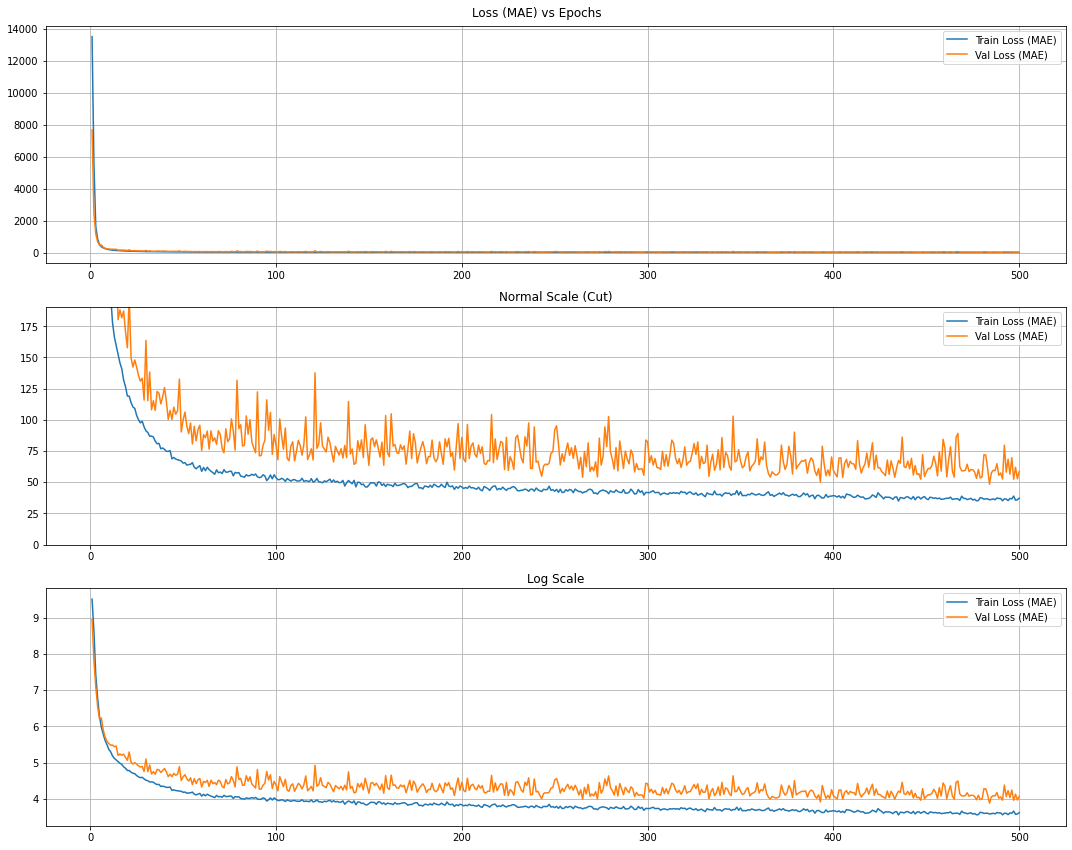

 __  __            ______ 
|  \/  |    /\    |  ____|
| \  / |   /  \   | |__   
| |\/| |  / /\ \  |  __|  
| |  | | / ____ \ | |____ 
|_|  |_|/_/    \_\|______|
                          
                          



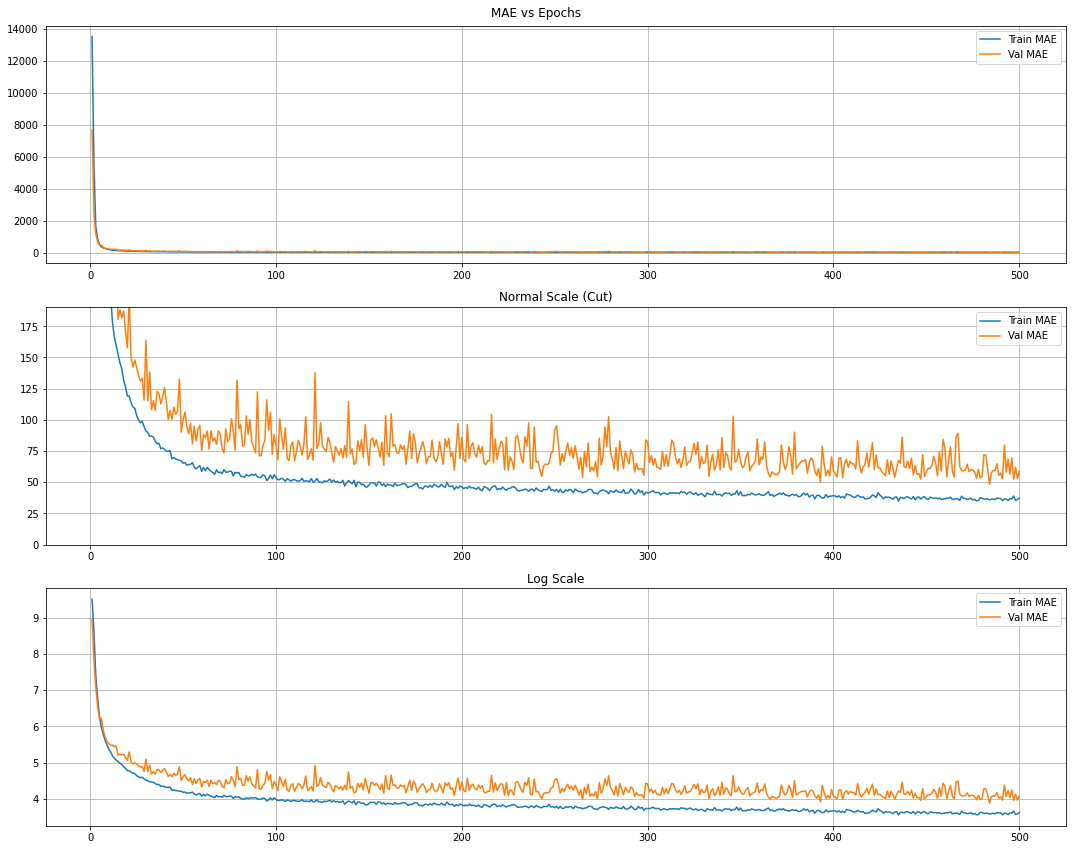

 __  __   _____  ______ 
|  \/  | / ____||  ____|
| \  / || (___  | |__   
| |\/| | \___ \ |  __|  
| |  | | ____) || |____ 
|_|  |_||_____/ |______|
                        
                        



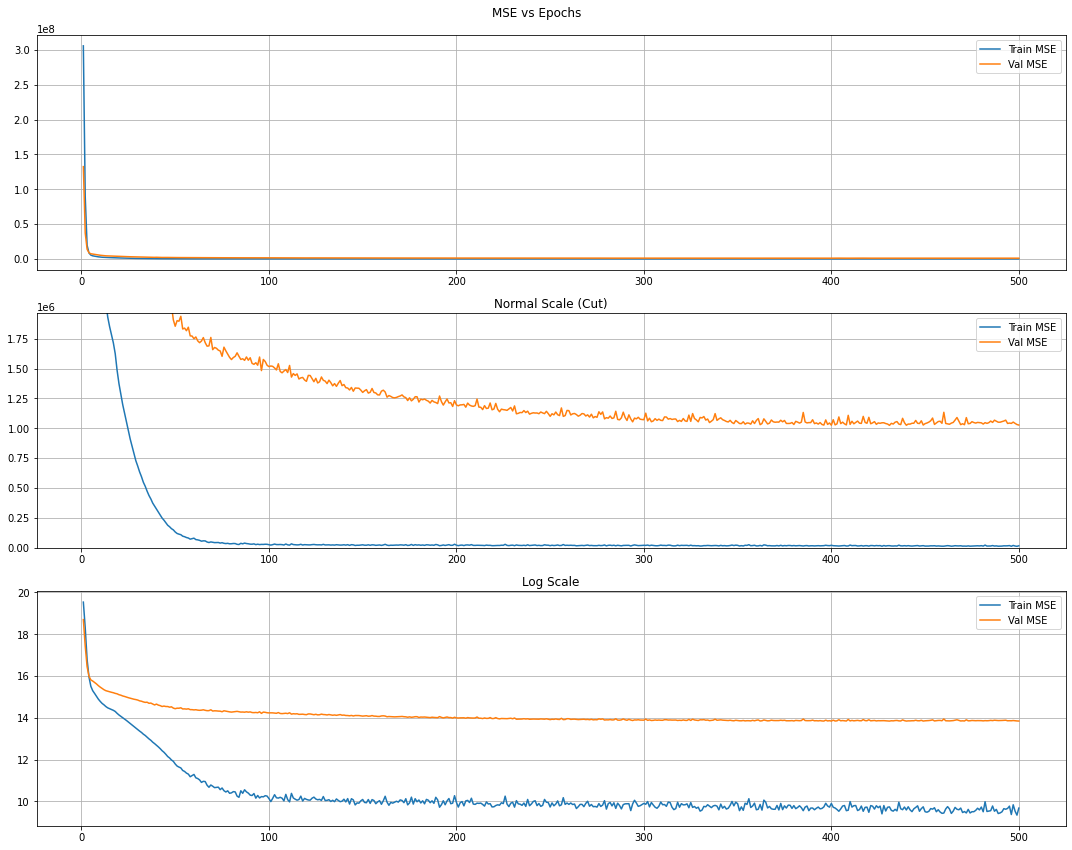

 _____   __  __   _____  ______ 
|  __ \ |  \/  | / ____||  ____|
| |__) || \  / || (___  | |__   
|  _  / | |\/| | \___ \ |  __|  
| | \ \ | |  | | ____) || |____ 
|_|  \_\|_|  |_||_____/ |______|
                                
                                



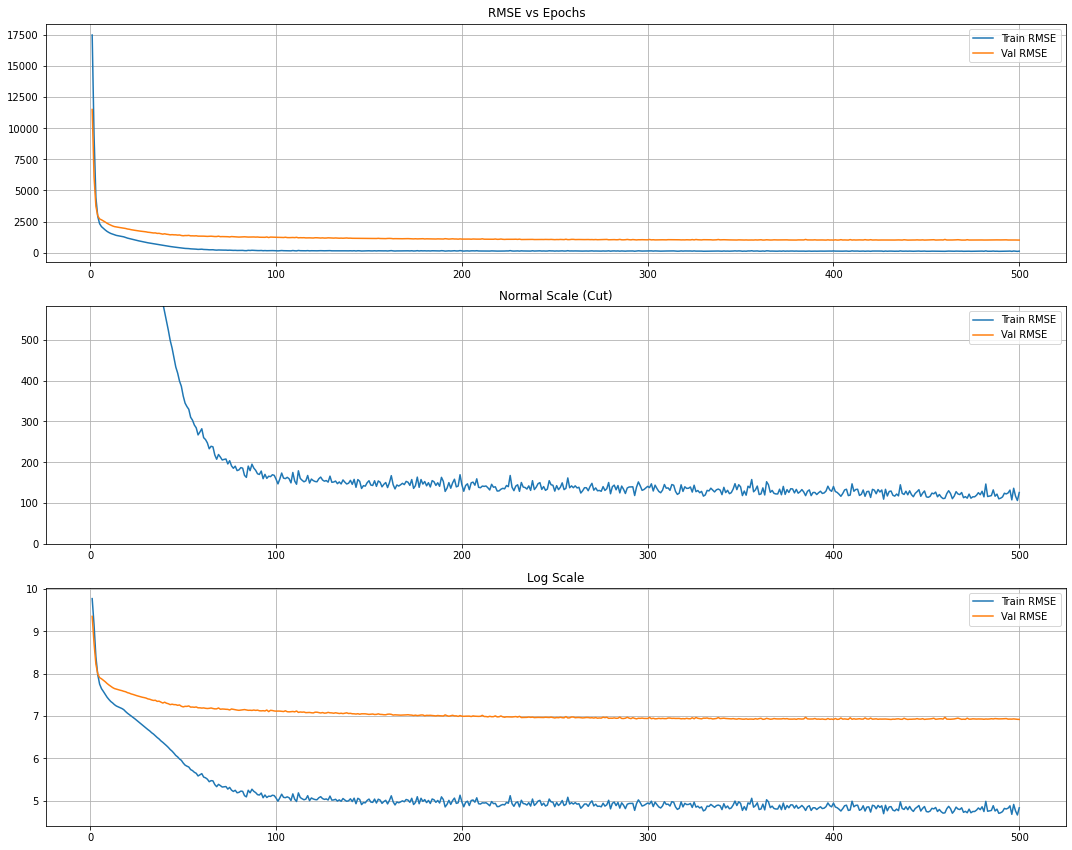

In [104]:
from math import log, sqrt


def plot_curve(metric, tr_data, val_data):
    epochs = range(1, len(tr_data) + 1)
    plt.figure(figsize=(15, 12))
    plt.suptitle(f"{metric} vs Epochs")

    # Normal Scale
    plt.title("Normal Scale")
    plt.subplot(3, 1, 1)
    plt.plot(epochs, tr_data, label=f'Train {metric}')
    plt.plot(epochs, val_data, label=f'Val {metric}')
    plt.legend()
    plt.grid()

    # Log Scale
    plt.subplot(3, 1, 2)
    plt.title("Normal Scale (Cut)")
    plt.ylim(0, np.average(max(tr_data, val_data)) * 2)
    plt.plot(epochs, tr_data, label=f'Train {metric}')
    plt.plot(epochs, val_data, label=f'Val {metric}')
    plt.legend()
    plt.grid()

    # Log Scale
    plt.subplot(3, 1, 3)
    plt.title("Log Scale")
    plt.plot(epochs, np.log(tr_data), label=f'Train {metric}')
    plt.plot(epochs, np.log(val_data), label=f'Val {metric}')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

print('=' * 110)
tprint("Loss", font='big')
plot_curve('Loss (MAE)', per_epoch_tr_loss, per_epoch_val_loss)
print('=' * 110)
tprint("MAE", font='big')
plot_curve('MAE', per_epoch_tr_mae, per_epoch_val_mae)
print('=' * 110)
tprint("MSE", font='big')
plot_curve('MSE', per_epoch_tr_mse, per_epoch_val_mse)
print('=' * 110)
tprint("RMSE", font='big')
plot_curve('RMSE', per_epoch_tr_rmse, per_epoch_val_rmse)


# 5. Future Work:
- Describe what could follow your work.


# 6. Contributions:
- Describe the contributions of each team member.